In [1]:
library(parallel)

In [2]:
library(tidyverse)

source("../R/process_slim_output.R")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



Calculate the mean distance between a subset of sites from the admixture array

In [3]:
array_sites <-
    read_tsv("../clean_data/ice_age.tsv")

sample_n(array_sites, 50000) %>%
    arrange(chrom, pos) %>% 
    group_by(chrom) %>%
    summarise(avg_dist=mean(diff(pos))) %>%
    .[["avg_dist"]] %>% 
    mean

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.


[1] 56984.65

In [4]:
snapshots <- mclapply(c(1,2,3,4,5,10, 100, 2200), function(gen) {
    slim_file <- read_slim_file(paste0("../simulations/different_models/constant__h_0.5__init_nea_0.1__rep_1__dump_gen_", gen, ".txt"))

    # get the Ne of modern humans in this generation
    N <- filter(read_populations(slim_file), pop_id == "p3")$pop_size

    # get info about the introgressed deleterious Nea. mutations
    # (anotate with the model, population origin, generation and frequency)
    nea_muts <-
        bind_rows(read_mutations(slim_file, "m1", "p2"),
                  read_mutations(slim_file, "m2", "p2")) %>%
        mutate(mutations="Nea", freq=count / (2 * N),
               gen=gen)
    nea_muts
})

muts <- bind_rows(snapshots)

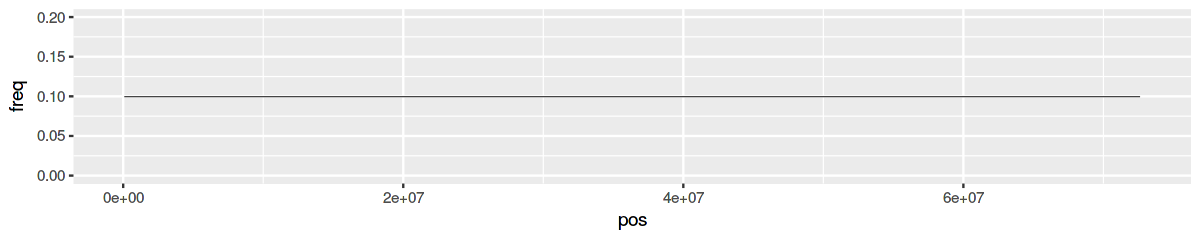

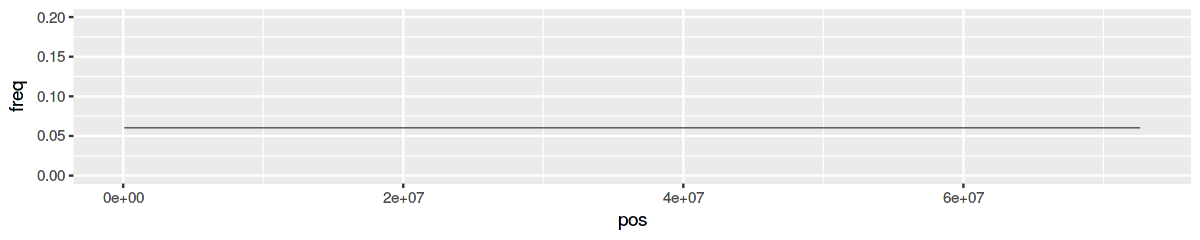

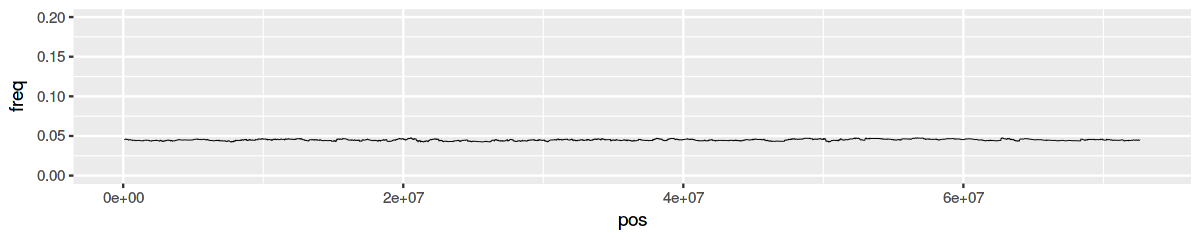

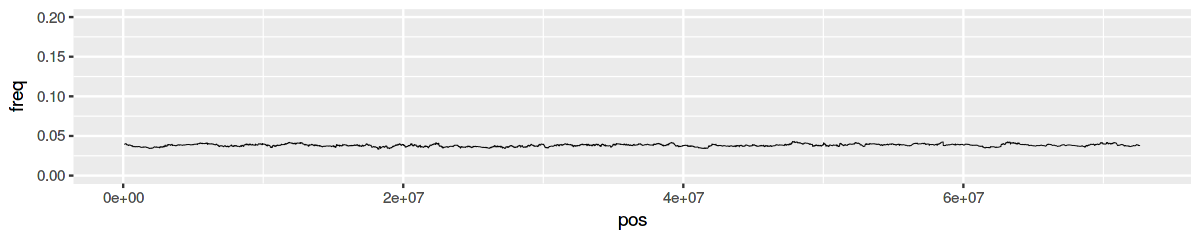

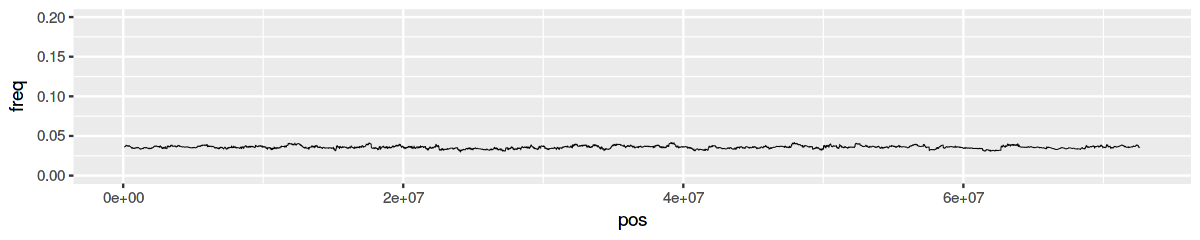

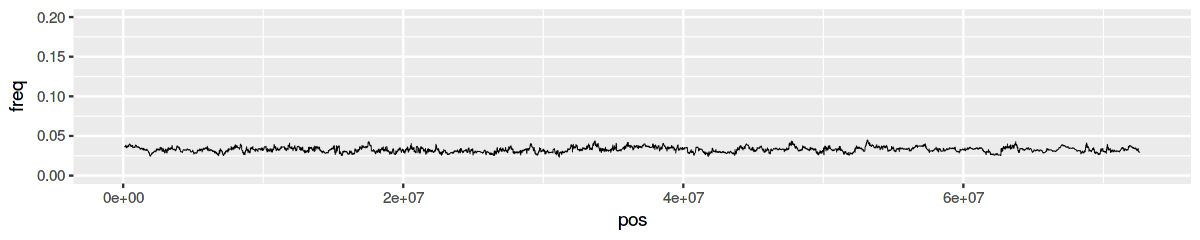

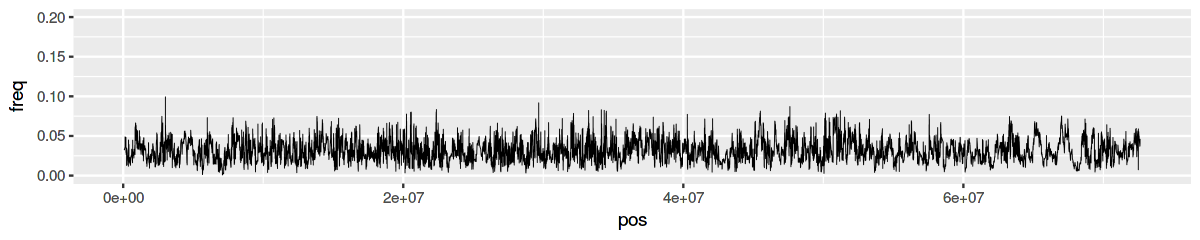

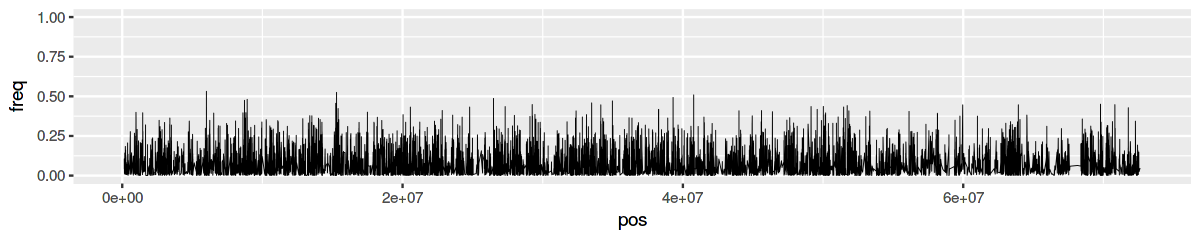

In [5]:
options(repr.plot.width=10, repr.plot.height=2)

for (g in c(1,2,3,4,5,10, 100)) {
    print(ggplot(filter(muts, gen == g), aes(pos, freq)) + geom_line(size=0.2) + ylim(0, 0.2))
}


print(ggplot(filter(muts, gen == 2200), aes(pos, freq)) + geom_line(size=0.2) + ylim(0, 1))

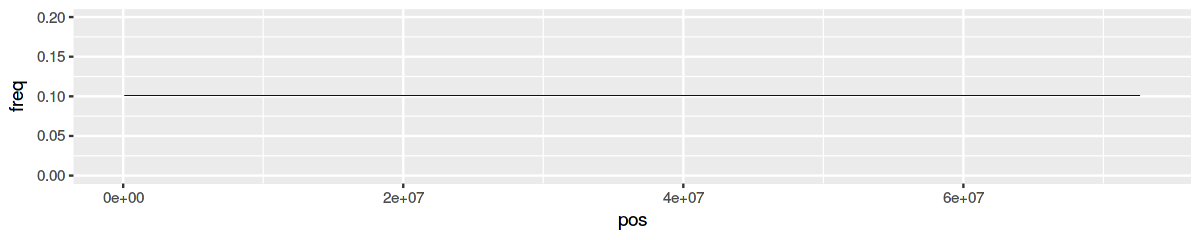

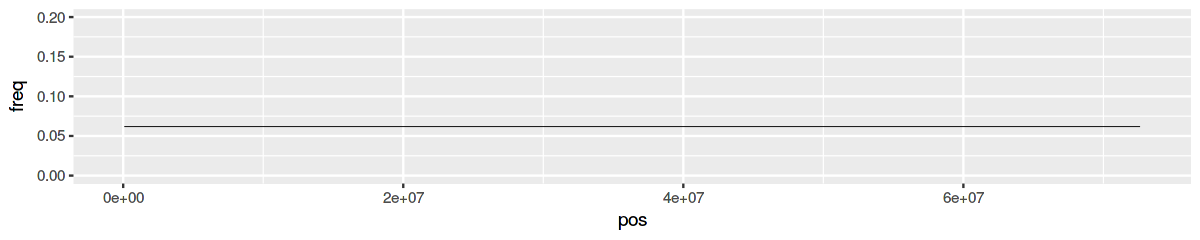

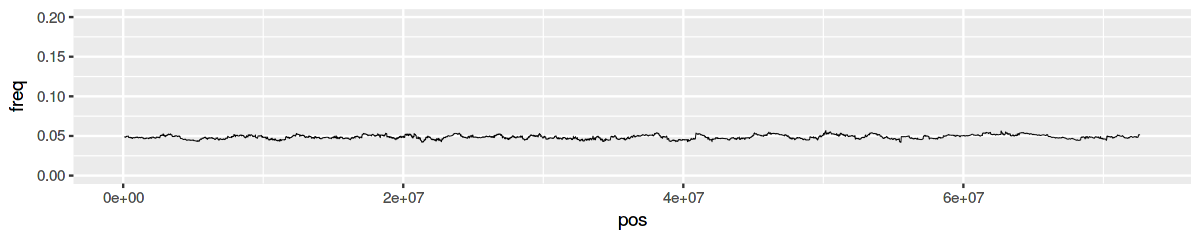

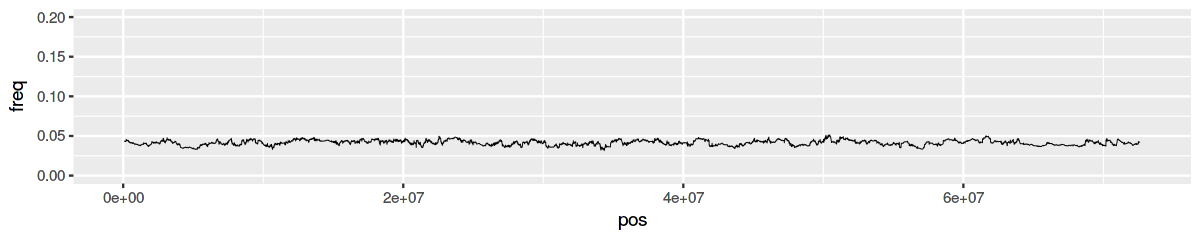

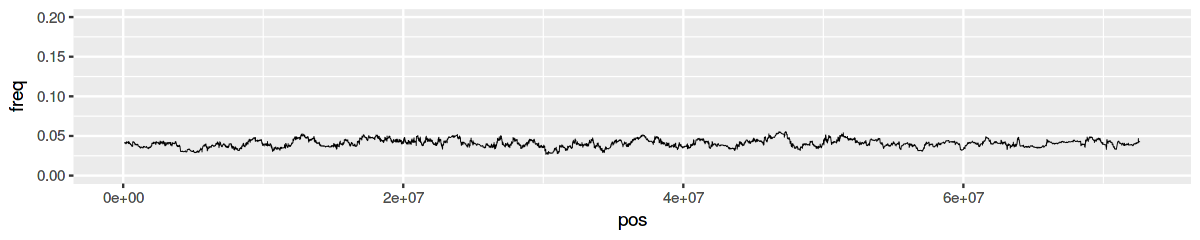

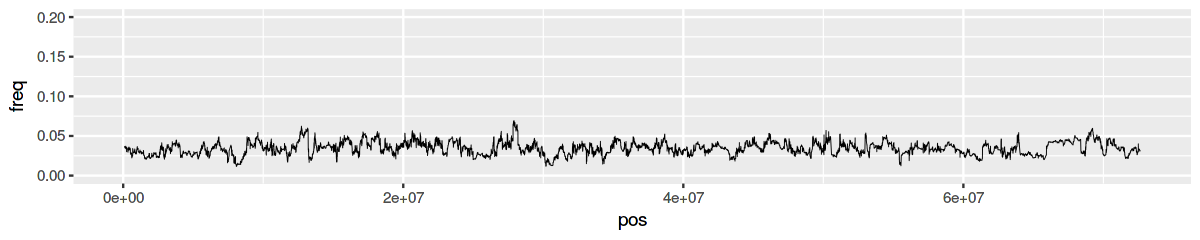

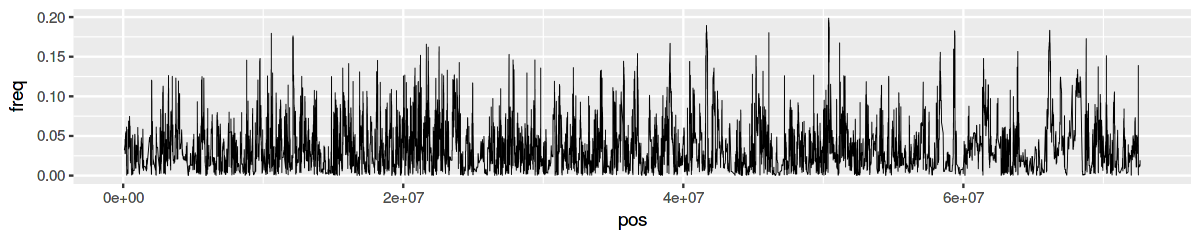

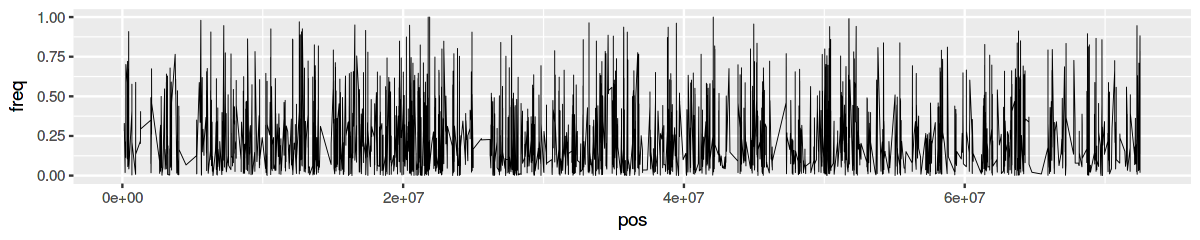

In [7]:
options(repr.plot.width=10, repr.plot.height=2)

for (g in c(1,2,3,4,5,10, 100)) {
    print(ggplot(filter(muts, gen == g), aes(pos, freq)) + geom_line(size=0.2) + ylim(0, 0.2))
}


print(ggplot(filter(muts, gen == 2200), aes(pos, freq)) + geom_line(size=0.2) + ylim(0, 1))